In [1]:
#import dependencies

import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import time
from pprint import pprint as pp
import sqlite3
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve, average_precision_score, auc
from sklearn.svm import SVC, SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from matplotlib import pyplot




In [2]:
# create connection to database
warnings.filterwarnings('ignore')

con = sqlite3.connect("db/movies.db")
sql = f"""
   SELECT * FROM movie_data
   """

# bring in db to pandas dataframe
movieDf = pd.read_sql(sql, con)
movieDf.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,gross_margin,successful,rating_numeric,director_score,actor_1_score,actor_2_score,actor_3_score,imdb_num_code,release_date,success_bins
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,0.688365,1,3,3.091853,1.520767,1.747604,2.066294,tt0499549,2009-12-10,extreme success
1,Color,Stephen Sommers,106.0,106.0,208.0,855.0,Jason Flemyng,3000.0,11146409.0,Action|Adventure|Horror|Sci-Fi,...,-3.037175,0,4,1.766773,3.041534,5.825346,2.066294,tt0118956,1998-01-30,no success
2,Color,Terrence Malick,222.0,150.0,0.0,855.0,Michael Greyeyes,23000.0,12712093.0,Biography|Drama|History|Romance,...,-1.359958,0,3,1.325080,8.364217,0.582535,2.066294,tt0402399,2005-12-25,no success
3,Color,Brian Robbins,76.0,98.0,48.0,722.0,Joel David Moore,21000.0,61112916.0,Comedy|Family|Fantasy,...,0.181842,1,2,2.650160,9.884984,1.747604,2.066294,tt0393735,2006-03-09,moderate success
4,Color,Brad Peyton,178.0,94.0,62.0,722.0,Dwayne Johnson,14000.0,103812241.0,Action|Adventure|Comedy|Family|Fantasy|Sci-Fi,...,0.239011,1,2,1.325080,2.661342,1.747604,2.066294,tt1397514,2012-01-19,average success


In [3]:
# review columns
movieDf.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes', 'revenue',
       'gross_margin', 'successful', 'rating_numeric', 'director_score',
       'actor_1_score', 'actor_2_score', 'actor_3_score', 'imdb_num_code',
       'release_date', 'success_bins'],
      dtype='object')

In [4]:
# create table for model purposes
modelDf = movieDf[["duration","facenumber_in_poster","rating_numeric","budget","revenue","gross_margin", "successful","director_score","actor_1_score","actor_2_score","actor_3_score"]]
modelDf = modelDf.dropna()

modelDf.head(100)

,duration,facenumber_in_poster,rating_numeric,budget,revenue,gross_margin,successful,director_score,actor_1_score,actor_2_score,actor_3_score
0,178.0,0.0,3,237000000.0,523505847.0,0.688365,1,3.091853,1.520767,1.747604,2.066294
1,106.0,0.0,4,45000000.0,-33853591.0,-3.037175,0,1.766773,3.041534,5.825346,2.066294
2,150.0,0.0,3,30000000.0,-17287907.0,-1.359958,0,1.325080,8.364217,0.582535,2.066294
3,98.0,0.0,2,50000000.0,11112916.0,0.181842,1,2.650160,9.884984,1.747604,2.066294
4,94.0,3.0,2,79000000.0,24812241.0,0.239011,1,1.325080,2.661342,1.747604,2.066294
5,146.0,4.0,4,100000000.0,-4671063.0,-0.048999,0,0.441693,0.760383,0.582535,2.066294
6,90.0,0.0,3,25000000.0,-6139597.0,-0.325528,0,2.650160,0.380192,1.747604,0.688765
7,121.0,0.0,4,83000000.0,-16137932.0,-0.241362,0,2.208466,1.520767,2.912673,2.066294
8,101.0,1.0,4,42000000.0,-28791977.0,-2.179885,0,0.883387,0.760383,0.582535,2.066294
9,110.0,1.0,4,45000000.0,25001065.0,0.357153,1,0.883387,0.760383,0.582535,2.066294


In [22]:
modelDf["successful"].value_counts()

1    2013
0    1725
Name: successful, dtype: int64

In [39]:
# Assign X (data) and y (target)
X = modelDf[["rating_numeric","director_score","actor_1_score","actor_2_score","actor_3_score"]]
y = modelDf["successful"].values.reshape(-1, 1)
print(X.shape, y.shape)

(3738, 5) (3738, 1)


In [50]:
# split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1158, train_size=0.9, stratify=y)

# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)

In [51]:
pd.DataFrame(y_test)[0].value_counts()

1    201
0    173
Name: 0, dtype: int64

In [52]:
# transform the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Logistic Regression Model 

In [39]:
#build logistic model 
model = LogisticRegression()

#fit on training data
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
# Use our model to predict a value
predicted = model.predict(X_test_scaled)

# Score the prediction with mse and r2
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)
testing_score = model.score(X_test_scaled,y_test)

print(f"testing_score: {testing_score}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

testing_score: 0.5668449197860963
Mean Squared Error (MSE): 0.43315508021390375
R-squared (R2 ): -0.7403968373656205


# Deep Neural Network

In [53]:
# creating the empty squential network
modelNN = Sequential()

In [54]:
# Add the first layer where the input dimensions are the 6 columns of the training data
modelNN.add(Dense(units=24, activation='relu', input_dim=5))

In [55]:
# Add the hidden layer
modelNN.add(Dense(units=24, activation='relu'))

In [56]:
# Add output layer 
modelNN.add(Dense(units=2, activation='softmax'))

In [57]:
# Compile the model using the adaptive learning rate optimizer "adam", spare_categorical_crossentropy
# for the loss function since we did not one-hot encode the labels and used accuracy for the training metrics.
modelNN.compile(optimizer='adadelta',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
# Use the training data to fit (train) the model
modelNN.fit(
    X_train_scaled,
    y_train,
    epochs=200,
    shuffle=True,
    verbose=2
)

Epoch 1/200
 - 0s - loss: 0.6953 - acc: 0.5312
Epoch 2/200
 - 0s - loss: 0.6849 - acc: 0.5592
Epoch 3/200
 - 0s - loss: 0.6829 - acc: 0.5583
Epoch 4/200
 - 0s - loss: 0.6808 - acc: 0.5681
Epoch 5/200
 - 0s - loss: 0.6795 - acc: 0.5782
Epoch 6/200
 - 0s - loss: 0.6780 - acc: 0.5737
Epoch 7/200
 - 0s - loss: 0.6774 - acc: 0.5707
Epoch 8/200
 - 0s - loss: 0.6768 - acc: 0.5761
Epoch 9/200
 - 0s - loss: 0.6761 - acc: 0.5725
Epoch 10/200
 - 0s - loss: 0.6754 - acc: 0.5779
Epoch 11/200
 - 0s - loss: 0.6748 - acc: 0.5755
Epoch 12/200
 - 0s - loss: 0.6741 - acc: 0.5826
Epoch 13/200
 - 0s - loss: 0.6737 - acc: 0.5868
Epoch 14/200
 - 0s - loss: 0.6733 - acc: 0.5749
Epoch 15/200
 - 0s - loss: 0.6730 - acc: 0.5785
Epoch 16/200
 - 0s - loss: 0.6714 - acc: 0.5820
Epoch 17/200
 - 0s - loss: 0.6712 - acc: 0.5817
Epoch 18/200
 - 0s - loss: 0.6712 - acc: 0.5847
Epoch 19/200
 - 0s - loss: 0.6706 - acc: 0.5850
Epoch 20/200
 - 0s - loss: 0.6705 - acc: 0.5841
Epoch 21/200
 - 0s - loss: 0.6692 - acc: 0.5835
E

Epoch 171/200
 - 0s - loss: 0.6416 - acc: 0.6249
Epoch 172/200
 - 0s - loss: 0.6414 - acc: 0.6243
Epoch 173/200
 - 0s - loss: 0.6421 - acc: 0.6254
Epoch 174/200
 - 0s - loss: 0.6423 - acc: 0.6287
Epoch 175/200
 - 0s - loss: 0.6425 - acc: 0.6201
Epoch 176/200
 - 0s - loss: 0.6419 - acc: 0.6284
Epoch 177/200
 - 0s - loss: 0.6424 - acc: 0.6246
Epoch 178/200
 - 0s - loss: 0.6414 - acc: 0.6246
Epoch 179/200
 - 0s - loss: 0.6404 - acc: 0.6323
Epoch 180/200
 - 0s - loss: 0.6418 - acc: 0.6213
Epoch 181/200
 - 0s - loss: 0.6407 - acc: 0.6335
Epoch 182/200
 - 0s - loss: 0.6419 - acc: 0.6219
Epoch 183/200
 - 0s - loss: 0.6412 - acc: 0.6237
Epoch 184/200
 - 0s - loss: 0.6413 - acc: 0.6254
Epoch 185/200
 - 0s - loss: 0.6407 - acc: 0.6266
Epoch 186/200
 - 0s - loss: 0.6410 - acc: 0.6329
Epoch 187/200
 - 0s - loss: 0.6401 - acc: 0.6231
Epoch 188/200
 - 0s - loss: 0.6415 - acc: 0.6317
Epoch 189/200
 - 0s - loss: 0.6398 - acc: 0.6237
Epoch 190/200
 - 0s - loss: 0.6403 - acc: 0.6219
Epoch 191/200
 - 0s 

In [59]:
# evaluate model by using test data
model_loss, model_accuracy = modelNN.evaluate(
    X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

 - 0s - loss: 0.7056 - acc: 0.5749
Loss: 0.7056081604192601, Accuracy: 0.5748662948608398


# Calculate ROC Curve vs Precision Recall Curve

##### Generally, the use of ROC curves and precision-recall curves are as follows:
#### ROC curves should be used when there are roughly equal numbers of observations for each class.
#### Precision-Recall curves should be used when there is a moderate to large class imbalance.

In [51]:
# predict probabilities
probs = model.predict_proba(X_test_scaled)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

In [53]:
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)

AUC: 0.557


In [54]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

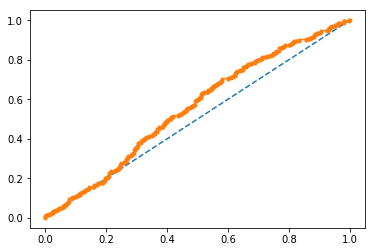

In [56]:
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

# Precision Recall Curve

In [60]:
# predict class values
yClass = model.predict(X_test_scaled)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
# calculate F1 score
f1 = f1_score(y_test, yClass)
# calculate precision-recall AUC
auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))

f1=0.648 auc=0.568 ap=0.569


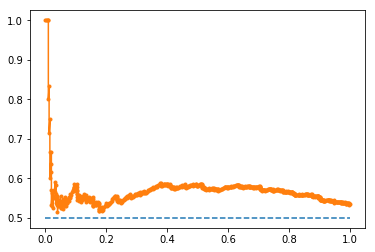

In [61]:
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()

# Grid Search / Cross Validation

In [25]:
# import dependencies from sklearn, build model using "rbf" kernel for the support vector classifier and bring in
# hyperparameters "C" and "gamma"

from sklearn.model_selection import GridSearchCV
modelGS = SVC(kernel='rbf')
param_grid = {'C': [.01, 1, 10, 100, 1000],
              'gamma': [0.0001, 0.001, 0.01,]}
grid = GridSearchCV(modelGS, param_grid, verbose=3)

In [26]:
grid.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] C=0.01, gamma=0.0001 ............................................
[CV] ................ C=0.01, gamma=0.0001, score=0.538, total=   0.1s
[CV] C=0.01, gamma=0.0001 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................ C=0.01, gamma=0.0001, score=0.538, total=   0.1s
[CV] C=0.01, gamma=0.0001 ............................................
[CV] ................ C=0.01, gamma=0.0001, score=0.538, total=   0.1s
[CV] C=0.01, gamma=0.001 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ................. C=0.01, gamma=0.001, score=0.538, total=   0.1s
[CV] C=0.01, gamma=0.001 .............................................
[CV] ................. C=0.01, gamma=0.001, score=0.538, total=   0.1s
[CV] C=0.01, gamma=0.001 .............................................
[CV] ................. C=0.01, gamma=0.001, score=0.538, total=   0.1s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .................. C=0.01, gamma=0.01, score=0.538, total=   0.1s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .................. C=0.01, gamma=0.01, score=0.538, total=   0.1s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .................. C=0.01, gamma=0.01, score=0.538, total=   0.1s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.538, total=   0.1s
[CV] C=1, gamma=0.0001 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    6.9s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [27]:
# Linear SVC - best parameters and score for the data
print(grid.best_params_)
print(grid.best_score_)

{'C': 1000, 'gamma': 0.01}
0.5605917532263142


In [ ]:
# store dataframe in a sqlite db
con = sqlite3.connect("db/movies.db")
movies.to_sql("movie_data", con, if_exists="replace", index=False)
# commit the changes and close the connection
con.commit()
con.close()